# Установка библиотеки ultralytics

In [1]:
# разкоментировать при первом запуске
!pip install ultralytics

# Импорты библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image, ImageEnhance
import shutil
import torch
from ultralytics import YOLO
import random

# Загружаем датасет и фиксим в нем разметку

In [ ]:
df = pd.read_csv("/kaggle/input/sila-dataset/defects.csv", delimiter =";")

# фикс разметки и удаление строк без класса
df.rename(columns={'length': 'width', 'width': 'length'}, inplace=True)
df['y_left_bottom'] = df.apply(lambda row: row['y_left_bottom'] - row['length'], axis=1)
df = df.dropna(subset=['main_class'])

df.head()

# Добавляем название и класс без дефектов к картинкам которые не были размечены

In [ ]:
list_of_defects = list(df["filename"])
folder_path = '/kaggle/input/sila-dataset/data'
all_files = os.listdir(folder_path)
new_files = [file for file in all_files if file not in list_of_defects]


new_files_df = pd.DataFrame({'filename': new_files})


df = pd.concat([df, new_files_df], ignore_index=True)

df["main_class"].fillna('без дефектов', inplace=True)
df

# Итак здесь раскидываем по папкам и делаем аугментацию данных и кроп а так же создаем аннотации к картинкам

In [ ]:
image_folder = '/kaggle/input/sila-dataset/data'
annotations_file = df  
output_zip_path = '/kaggle/working/dataset.zip' 

In [ ]:
for split in ['train', 'val']:
    for folder in ['images', 'labels']:
        os.makedirs(os.path.join(f'/kaggle/working/{split}', folder), exist_ok=True)
    for class_name in ['царапины', 'битые пиксели', 'проблемы с клавишами', 'замок', 'отсутствует шуруп', 'сколы', 'без дефектов']:
        os.makedirs(os.path.join(f'/kaggle/working/{split}/images', class_name), exist_ok=True)
        os.makedirs(os.path.join(f'/kaggle/working/{split}/labels', class_name), exist_ok=True)

In [ ]:
def crop_and_augment(image, bbox, target_size=640):
    x_left_bottom, y_left_bottom, width, length = bbox
    
    img_width, img_height = image.size

    if any(np.isnan([x_left_bottom, y_left_bottom, width, length])):
        crop_x = (img_width - target_size) // 2
        crop_y = (img_height - target_size) // 2

        crop_x = min(max(crop_x, 0), img_width - target_size)
        crop_y = min(max(crop_y, 0), img_height - target_size)

        cropped_image = image.crop((crop_x, crop_y, crop_x + target_size, crop_y + target_size))
        return cropped_image, None 

    img_width, img_height = image.size

    crop_x = min(max(int(x_left_bottom - (target_size - width) // 2), 0), img_width - target_size)
    crop_y = min(max(int(y_left_bottom - (target_size - length) // 2), 0), img_height - target_size)

    cropped_image = image.crop((crop_x, crop_y, crop_x + target_size, crop_y + target_size))

    new_x_left_bottom = x_left_bottom - crop_x
    new_y_left_bottom = y_left_bottom - crop_y
    new_bbox = [new_x_left_bottom, new_y_left_bottom, width, length]

    return cropped_image, new_bbox

In [ ]:
class_mapping = {
    'царапины': 0,
    'битые пиксели': 1,
    'проблемы с клавишами': 2,
    'замок': 3,
    'отсутствует шуруп': 4,
    'сколы': 5,
    'без дефектов': 6
}

In [ ]:
for index, row in df.iterrows():
    filename = row['filename']
    x_left_bottom = row['x_left_bottom']
    y_left_bottom = row['y_left_bottom']
    width = row['width']
    length = row['length']
    main_class = row['main_class']

    bbox = [x_left_bottom, y_left_bottom, width, length]
    image_path = os.path.join(image_folder, filename)

    
    class_folder = main_class.lower()
    split = 'train' if np.random.rand() > 0.2 else 'val'

    class_image_folder = os.path.join(f'/kaggle/working/{split}/images', class_folder)
    class_annotation_folder = os.path.join(f'/kaggle/working/{split}/labels', class_folder)
    
    saved_image_path = os.path.join(class_image_folder, filename)
    annotation_path = os.path.join(class_annotation_folder, filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.JPG', '.txt'))

    if os.path.exists(image_path):
        with Image.open(image_path) as img:
            aug_img, new_bbox = crop_and_augment(img, bbox, target_size=640)
            aug_img.save(saved_image_path)

            with open(annotation_path, 'w') as f:
                if new_bbox is None:  # сохраняем только метку класса
                    f.write(f"{class_mapping[main_class]}\n")
                else:
                    image_width, image_height = aug_img.size
                    x_center = (new_bbox[0] + new_bbox[2] / 2) / image_width
                    y_center = (new_bbox[1] + new_bbox[3] / 2) / image_height
                    norm_width = new_bbox[2] / image_width
                    norm_height = new_bbox[3] / image_height

                    f.write(f"{class_mapping[main_class]} {x_center} {y_center} {norm_width} {norm_height}\n")
    else:
        print(f"Файл не найден: {image_path}")

shutil.make_archive('/kaggle/working/dataset', 'zip', '/kaggle/working')

print(f"Архив создан и сохранен по пути: {output_zip_path}")

# Обучение ёлы

In [12]:
data_yaml_path = '/kaggle/input/sila-dataset/data.yaml' 
epochs = 10 
img_size = 640
batch = 8

In [13]:
model = YOLO('/kaggle/input/sila-dataset/yolo11n.pt') 

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
results = model.train(data=data_yaml_path, epochs=epochs, imgsz=img_size, batch=batch)  

engine/trainer: task=detect, mode=train, model=/kaggle/input/sila-dataset/yolo11n.pt, data=/kaggle/input/sila-dataset/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript,

100%|██████████| 22.2M/22.2M [00:00<00:00, 48.3MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 319 layers, 2,591,010 parameters, 2,590,994 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train3', view at http://localhost:6006/


wandb: Currently logged in as: timmmofeydeykun (timmmofeydeykun-yoptascript). Use `wandb login --relogin` to force relogin


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /kaggle/input/sila-dataset/train/labels/битые пиксели... 67 images, 0 backgrounds, 5 corrupt: 100%|██████████| 67/67 [00:00<00:00, 196.99it/s]

train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/проблемы с клавишами/2024-01-15 17-57-27.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6516]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2023-12-26 15-38-08.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.1953]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2024-01-15 14-47-34.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.0766]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2024-01-15 16-27-01.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7062]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2024-01-15 18-27-22.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.4766]
train: WARNING ⚠️ Cache directory /kaggle/input/sila-dataset/train/labels is not writeab


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/sila-dataset/val/labels/битые пиксели... 20 images, 0 backgrounds, 1 corrupt: 100%|██████████| 20/20 [00:00<00:00, 162.64it/s]

val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/царапины/2024-01-15 18-28-48.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2078]
val: WARNING ⚠️ Cache directory /kaggle/input/sila-dataset/val/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.57G      3.449      7.259      3.549          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         19         19   0.000351      0.265     0.0141    0.00428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.46G      3.378      7.332      3.454          6        640: 100%|██████████| 8/8 [00:01<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]

                   all         19         19   0.000221      0.167    0.00873    0.00175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.46G      3.051      7.191      3.164          6        640: 100%|██████████| 8/8 [00:01<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]

                   all         19         19   0.000221      0.167    0.00873    0.00175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.46G      2.677      6.482      2.855          6        640: 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


                   all         19         19   0.000383       0.25     0.0838     0.0334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.47G      2.614      6.179      2.756          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


                   all         19         19    0.00041       0.25     0.0835     0.0333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.46G      2.433      6.177      2.591          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.99it/s]


                   all         19         19   0.000446       0.25     0.0558     0.0387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.46G      2.346      5.991      2.431          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]

                   all         19         19   0.000449       0.25     0.0605     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.47G      2.247      5.793       2.42          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         19         19   0.000449       0.25     0.0602     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.46G      2.321      5.549      2.398          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         19         19   0.000444       0.25     0.0859     0.0505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.47G      2.104      5.528      2.294          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


                   all         19         19   0.000413       0.25      0.168        0.1

10 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


                   all         19         19   0.000414       0.25      0.168        0.1
         битые пиксели          1          1          0          0          0          0
                 замок         11         11          0          0          0          0
     отсутствует шуруп          2          2   0.000513        0.5     0.0128    0.00323
  проблемы с клавишами          1          1    0.00197          1      0.995      0.597
                 сколы          1          1          0          0          0          0
              царапины          3          3          0          0          0          0
Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train3


lr/pg0,▁▄▆▇██▇▆▄▂
lr/pg1,▁▄▆▇██▇▆▄▂
lr/pg2,▁▄▆▇██▇▆▄▂
metrics/mAP50(B),▁▁▁▄▄▃▃▃▄█
metrics/mAP50-95(B),▁▁▁▃▃▄▃▃▄█
metrics/precision(B),▅▁▁▆▇████▇
metrics/recall(B),█▁▁▇▇▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▆▄▄▃▂▂▂▁


# Отображение предсказаний модели


image 1/1 /kaggle/input/sila-dataset/train/images/битые пиксели/20240115_C223013936.jpg: 640x640 (no detections), 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


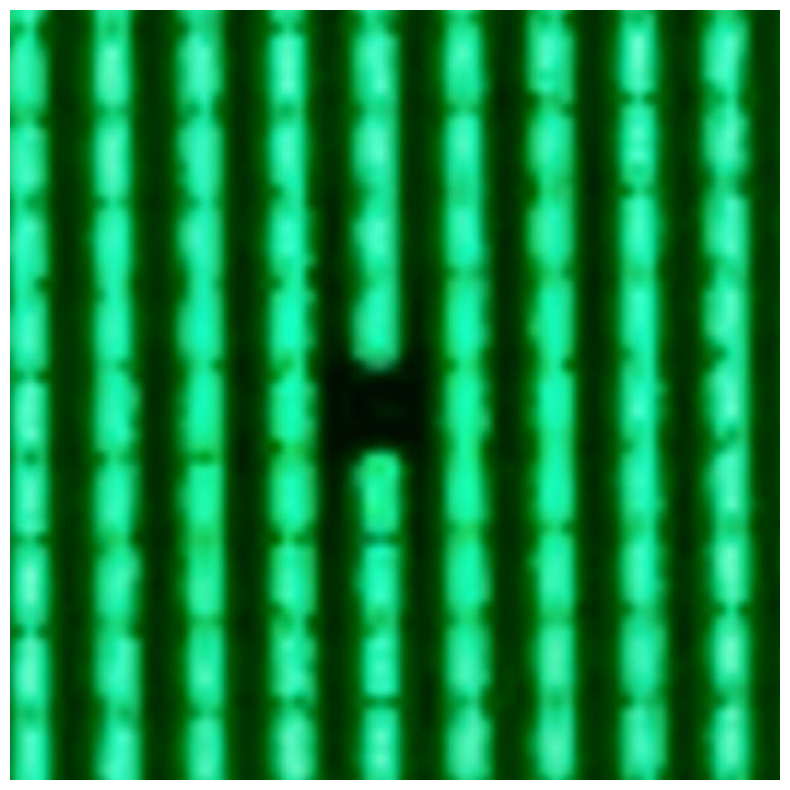

In [17]:
import cv2

model_load = YOLO('/kaggle/working/runs/detect/train3/weights/best.pt')

test_image_path = '/kaggle/input/sila-dataset/train/images/битые пиксели/20240115_C223013936.jpg'  # вставляем картинку которую хотим проверить
image = cv2.imread(test_image_path)


results = model_load(test_image_path)

for result in results[0].boxes:  
    x1, y1, x2, y2 = result.xyxy[0].tolist()  # коробка коорды
    confidence = result.conf[0].item()        # Уверенность
    class_id = int(result.cls[0].item())      # ID класса

    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # добавляем метку класса
    class_label = list(class_mapping.keys())[class_id]
    cv2.putText(image, f"{class_label} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

output_path = '/kaggle/working/prediction_with_boxes.jpg'
cv2.imwrite(output_path, image)
#plt.title(f"имя класса {class_label}")
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Далее будет код для перевода меток класса которые задетектила ёла чтобы из детекции получить классификацию такой простой способ классификации через детекцию

# Ответ на вопрос для любопытных почему пришлось фиксить разметку - в изначальном датасете были перепутаны местами ширина и высота, а так же координата x левого нижнего угла а координата y левого верхнего если возьмете изначальный датасет и попробуете запустить код ниже то увидите что квадратик появляется не там где надо) но фикс весьма простой если понимать как работает геометрия
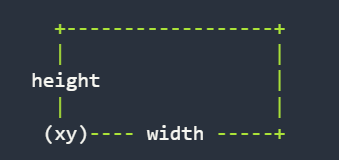

In [ ]:
def display_image_with_bbox(row, image_dir):
    img_path = os.path.join(image_dir, row['filename'])
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    
    x_lb = int(row['x_left_bottom'])
    y_lb = int(row['y_left_bottom'])
    length = int(row['length'])
    width_box =  int(row['width'])
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    
    rect = plt.Rectangle((x_lb, y_lb), width_box, length, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.title(f"картинка {row['filename']}")
    plt.axis('off')
    plt.show()
    

In [ ]:
display_image_with_bbox(df.iloc[80], image_folder)